台風の経路とTPGshipの経路の描画プログラム

描画したい範囲のデータを年間運用データから切り出して用意してください。

みやすさを考慮すると拠点から出発し、1つか2つの台風に追いついて発電している状態を切り出して持ってくる方が良いと思います。

ライブラリ読み込み

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import math
from numpy import linalg as LA
import cartopy.feature as cfeature
from PIL import Image
import matplotlib.patches as patches


データファイル読み取り

1.台風＆TPGship経路データ

2.台風経路データ

In [3]:
year = 2020

ship_typhoon_route_data = pl.read_csv(str(year) + "_sim_ver4.csv",encoding="shift-jis")
starttime = 1600084800
endtime = 1600992000
ship_typhoon_route_data = ship_typhoon_route_data.filter((pl.col("unixtime") >= starttime) & (pl.col("unixtime") <= endtime))
typhoon_data = pl.read_csv("typhoon_data_6hour_intervals_verpl/table" + str(year) + "_6_interval.csv",encoding="shift-jis")

In [4]:
year = 2018

ship_typhoon_route_data = pl.read_csv(str(year) + "_sim_ver4.csv",encoding="shift-jis")
#unixtimeで範囲指定
starttime = 1534701600
endtime = 1535932800
ship_typhoon_route_data = ship_typhoon_route_data.filter((pl.col("unixtime") >= starttime) & (pl.col("unixtime") <= endtime))

typhoon_data = pl.read_csv("typhoon_data_6hour_intervals_verpl/table" + str(year) + "_6_interval.csv",encoding="shift-jis")


北向きを0度、時計回りを正とする方位角の追加

In [4]:
ship_lon = ship_typhoon_route_data[:]['TPGSHIP LON'] # 経度データ読み込み
ship_lat = ship_typhoon_route_data[:]['TPGSHIP LAT'] # 緯度データ読み込み

ship_deg = []
base_vec = np.array([0,1])

ship_deg.append(0)

print(len(ship_lon))

for i in range(len(ship_lon)-1):
    num = i + 1
    x = ship_lon[num]-ship_lon[num-1]
    y = ship_lat[num]-ship_lat[num-1]
    ship_vec = np.array([x,y])

    I = np.inner(base_vec, ship_vec)
    n = LA.norm(base_vec) * LA.norm(ship_vec)
    if n != 0 :
        c = I / n
        deg = np.rad2deg(np.arccos(np.clip(c, -1.0, 1.0)))
    else:
        deg = np.nan
        print("error")

    if x < 0:
        deg = 360 - deg
    
    ship_deg.append(deg)


#print(ship_deg)
       

58


TPGshipの航路と台風の経路の描画

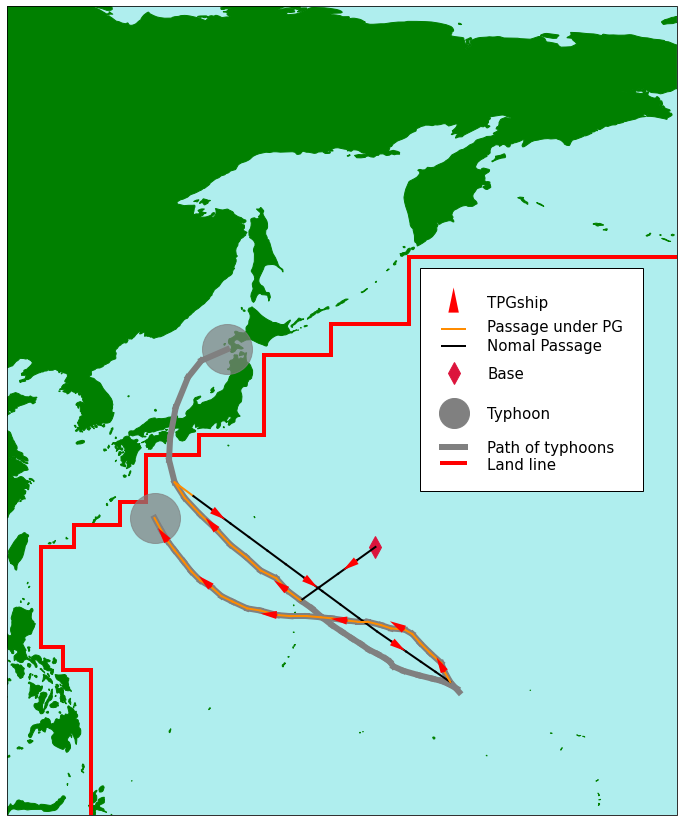

In [8]:
ship_lon = ship_typhoon_route_data[:]['TPGSHIP LON'] # 経度データ読み込み
ship_lat = ship_typhoon_route_data[:]['TPGSHIP LAT'] # 緯度データ読み込み

fig = plt.figure(figsize=(12,16)) # プロット領域の作成（matplotlib）
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # サブプロット作成時にcartopy呼び出し


ax.set_facecolor('paleturquoise')
land_h = cfeature.NaturalEarthFeature('physical', 'land', '50m')
ax.add_feature(land_h,color='g')
ax.set_extent([120, 180, 0, 70], ccrs.Geodetic())

r = patches.Rectangle(xy=(157, 29), width=20, height=20, ec='k', fc='w',zorder=3)
ax.add_patch(r)

#拠点&待機位置
base_lat = 24
base_lon = 153
ax.plot(base_lon,base_lat,'crimson',markersize=15,marker="d")

#台風の作図
TYnumdata = ship_typhoon_route_data.filter(pl.col("TARGET TYPHOON") != 0)
TY_num = TYnumdata.n_unique("TARGET TYPHOON")
TYs = TYnumdata.unique("TARGET TYPHOON")
TYs_list = TYs[:]["TARGET TYPHOON"]

#不可侵境界の設定
nonaggression_line_lat = [0,13,13,15,15,24,24,26,26,28,28,32.2,32.2,34,34,41.2,41.2,44,44,50,50]
nonaggression_line_lon = [127.5,127.5,125,125,123,123,126,126,130.1,130.1,132.4,132.4,137.2,137.2,143,143,149,149,156,156,180]

for i in range(len(nonaggression_line_lat)-1):
    ax.plot([nonaggression_line_lon[i],nonaggression_line_lon[i+1]],[nonaggression_line_lat[i],nonaggression_line_lat[i+1]],'red',linewidth=4)



for i in range(len(TYs_list)):
    TYdata = typhoon_data.filter((pl.col("TYPHOON NUMBER") == TYs_list[i]) & (pl.col("unixtime") <= endtime))
    typhoon_lon = TYdata[:]["LON"]
    typhoon_lat = TYdata[:]["LAT"]
    for j in range(len(typhoon_lon)-1):
        ax.plot([typhoon_lon[j],typhoon_lon[j+1]],[typhoon_lat[j],typhoon_lat[j+1]],'gray',linewidth=6)

    ax.plot(typhoon_lon[-1],typhoon_lat[-1],'grey',markersize=50,marker="o",alpha=0.7)

#航路
for i in range(len(ship_lon)-1):
    if ship_typhoon_route_data[i,"TPGSHIP STATUS"] == 1:
        ax.plot([ship_lon[i],ship_lon[i+1]],[ship_lat[i],ship_lat[i+1]],'darkorange',linewidth=2)
    else:
        ax.plot([ship_lon[i],ship_lon[i+1]],[ship_lat[i],ship_lat[i+1]],'black',linewidth=2)

#船の作図
u = []
u.append(0)
v = []
v.append(0)
for i in range(len(ship_lon)-1):
    num = i + 1
    u.append(ship_lon[num] - ship_lon[num-1])
    v.append(ship_lat[num] - ship_lat[num-1])

for i in range(len(ship_lon)-1):
    num = i + 1
    if (num == 1):
        size = 10
        
        vec_size = (np.sqrt((u[num])**2 + (v[num])**2))
        plt.quiver(ship_lon[num], ship_lat[num], u[num]/vec_size*size, v[num]/vec_size*size, color="red", linewidth = 0.25, headlength=6 , headaxislength=6, width=.004, scale=400.,zorder=5)
        
    if (np.mod(num,5) == 0) or (num == len(ship_lon)):
        size = 10
        
        vec_size = (np.sqrt((u[num])**2 + (v[num])**2))
        plt.quiver(ship_lon[num], ship_lat[num], u[num]/vec_size*size, v[num]/vec_size*size, color="red", linewidth = 0.25, headlength=6 , headaxislength=6, width=.004, scale=400.,zorder=5)
        

view_lon = 160
text_lon = 163
d_view_lat = 3
view_lat_1 = 45
lon_width = 2

ax.quiver(view_lon, view_lat_1, 0, 15, color="red", linewidth = 1.0, headwidth=5, headlength=12 , headaxislength=12, width=.02, scale=400.,zorder=4)
ax.text(text_lon, view_lat_1+0.5, "TPGship", size=15, color="black")

ax.plot([view_lon-lon_width/2,view_lon+lon_width/2],[view_lat_1 - d_view_lat/2,view_lat_1 - d_view_lat/2],'darkorange',linewidth=2,zorder=4)
ax.text(text_lon, view_lat_1 - d_view_lat/2-0.2, "Passage under PG", size=15, color="black",zorder=4)

ax.plot([view_lon-lon_width/2,view_lon+lon_width/2],[view_lat_1 - d_view_lat,view_lat_1 - d_view_lat],'black',linewidth=2,zorder=4)
ax.text(text_lon, view_lat_1 - d_view_lat-0.4, "Nomal Passage", size=15, color="black")

ax.plot(view_lon,view_lat_1 - 1.8*d_view_lat,'crimson',markersize=15,marker="d",zorder=4)
ax.text(text_lon, view_lat_1 - 1.8*d_view_lat-0.5, "Base", size=15, color="black",zorder=4)

ax.plot(view_lon,view_lat_1 - 3*d_view_lat,'grey',markersize=30,marker="o",zorder=4)
ax.text(text_lon, view_lat_1 - 3*d_view_lat-0.5, "Typhoon", size=15, color="black",zorder=4)

ax.plot([view_lon-lon_width/2,view_lon+lon_width/2],[view_lat_1 - 4*d_view_lat,view_lat_1 - 4*d_view_lat],'gray',linewidth=6,zorder=4)
ax.text(text_lon, view_lat_1 - 4*d_view_lat-0.5, "Path of typhoons", size=15, color="black",zorder=4)

ax.plot([view_lon-lon_width/2,view_lon+lon_width/2],[view_lat_1 - 4.5*d_view_lat,view_lat_1 - 4.5*d_view_lat],'red',linewidth=4,zorder=4)
ax.text(text_lon, view_lat_1 - 4.5*d_view_lat-0.5, "Land line", size=15, color="black",zorder=4)

plt.rc("svg", fonttype="none")
fig.savefig("sample.svg")


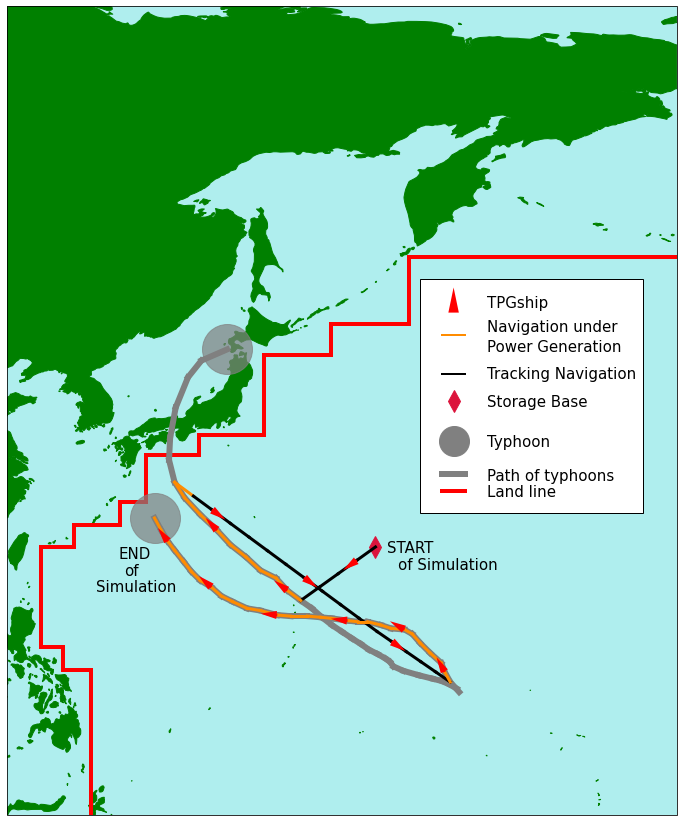

In [9]:
ship_lon = ship_typhoon_route_data[:]['TPGSHIP LON'] # 経度データ読み込み
ship_lat = ship_typhoon_route_data[:]['TPGSHIP LAT'] # 緯度データ読み込み

fig = plt.figure(figsize=(12,16)) # プロット領域の作成（matplotlib）
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # サブプロット作成時にcartopy呼び出し


ax.set_facecolor('paleturquoise')
land_h = cfeature.NaturalEarthFeature('physical', 'land', '50m')
ax.add_feature(land_h,color='g')
ax.set_extent([120, 180, 0, 70], ccrs.Geodetic())

r = patches.Rectangle(xy=(157, 27), width=20, height=21, ec='k', fc='w',zorder=3)
ax.add_patch(r)

#拠点&待機位置
base_lat = 24
base_lon = 153
ax.plot(base_lon,base_lat,'crimson',markersize=15,marker="d")

#台風の作図
TYnumdata = ship_typhoon_route_data.filter(pl.col("TARGET TYPHOON") != 0)
TY_num = TYnumdata.n_unique("TARGET TYPHOON")
TYs = TYnumdata.unique("TARGET TYPHOON")
TYs_list = TYs[:]["TARGET TYPHOON"]

#不可侵境界の設定
nonaggression_line_lat = [0,13,13,15,15,24,24,26,26,28,28,32.2,32.2,34,34,41.2,41.2,44,44,50,50]
nonaggression_line_lon = [127.5,127.5,125,125,123,123,126,126,130.1,130.1,132.4,132.4,137.2,137.2,143,143,149,149,156,156,180]

for i in range(len(nonaggression_line_lat)-1):
    ax.plot([nonaggression_line_lon[i],nonaggression_line_lon[i+1]],[nonaggression_line_lat[i],nonaggression_line_lat[i+1]],'red',linewidth=4)



for i in range(len(TYs_list)):
    TYdata = typhoon_data.filter((pl.col("TYPHOON NUMBER") == TYs_list[i]) & (pl.col("unixtime") <= endtime))
    typhoon_lon = TYdata[:]["LON"]
    typhoon_lat = TYdata[:]["LAT"]
    for j in range(len(typhoon_lon)-1):
        ax.plot([typhoon_lon[j],typhoon_lon[j+1]],[typhoon_lat[j],typhoon_lat[j+1]],'gray',linewidth=6)

    ax.plot(typhoon_lon[-1],typhoon_lat[-1],'grey',markersize=50,marker="o",alpha=0.7)

#航路
for i in range(len(ship_lon)-1):
    if ship_typhoon_route_data[i,"TPGSHIP STATUS"] == 1:
        ax.plot([ship_lon[i],ship_lon[i+1]],[ship_lat[i],ship_lat[i+1]],'darkorange',linewidth=3)
    else:
        ax.plot([ship_lon[i],ship_lon[i+1]],[ship_lat[i],ship_lat[i+1]],'black',linewidth=3)

#船の作図
u = []
u.append(0)
v = []
v.append(0)
for i in range(len(ship_lon)-1):
    num = i + 1
    u.append(ship_lon[num] - ship_lon[num-1])
    v.append(ship_lat[num] - ship_lat[num-1])

for i in range(len(ship_lon)-1):
    num = i + 1
    if (num == 1):
        size = 10
        
        vec_size = (np.sqrt((u[num])**2 + (v[num])**2))
        plt.quiver(ship_lon[num], ship_lat[num], u[num]/vec_size*size, v[num]/vec_size*size, color="red", linewidth = 0.25, headlength=6 , headaxislength=6, width=.004, scale=400.,zorder=5)
        
    if (np.mod(num,5) == 0) or (num == len(ship_lon)):
        size = 10
        
        vec_size = (np.sqrt((u[num])**2 + (v[num])**2))
        plt.quiver(ship_lon[num], ship_lat[num], u[num]/vec_size*size, v[num]/vec_size*size, color="red", linewidth = 0.25, headlength=6 , headaxislength=6, width=.004, scale=400.,zorder=5)
        

view_lon = 160
text_lon = 163
d_view_lat = 3
view_lat_1 = 45
lon_width = 2

ax.quiver(view_lon, view_lat_1, 0, 15, color="red", linewidth = 1.0, headwidth=5, headlength=12 , headaxislength=12, width=.02, scale=400.,zorder=4)
ax.text(text_lon, view_lat_1+0.5, "TPGship", size=15, color="black")

ax.plot([view_lon-lon_width/2,view_lon+lon_width/2],[view_lat_1 - d_view_lat/2-0.5,view_lat_1 - d_view_lat/2-0.5],'darkorange',linewidth=2,zorder=4)
ax.text(text_lon, view_lat_1 - d_view_lat/2-0.2, "Navigation under", size=15, color="black",zorder=4)

ax.text(text_lon, view_lat_1 - d_view_lat/2-2.0, "Power Generation", size=15, color="black",zorder=4)

view_lat_1 = 42.5

ax.plot([view_lon-lon_width/2,view_lon+lon_width/2],[view_lat_1 - d_view_lat,view_lat_1 - d_view_lat],'black',linewidth=2,zorder=4)
ax.text(text_lon, view_lat_1 - d_view_lat-0.4, "Tracking Navigation", size=15, color="black")

ax.plot(view_lon,view_lat_1 - 1.8*d_view_lat,'crimson',markersize=15,marker="d",zorder=4)
ax.text(text_lon, view_lat_1 - 1.8*d_view_lat-0.5, "Storage Base", size=15, color="black",zorder=4)

ax.plot(view_lon,view_lat_1 - 3*d_view_lat,'grey',markersize=30,marker="o",zorder=4)
ax.text(text_lon, view_lat_1 - 3*d_view_lat-0.5, "Typhoon", size=15, color="black",zorder=4)

ax.plot([view_lon-lon_width/2,view_lon+lon_width/2],[view_lat_1 - 4*d_view_lat,view_lat_1 - 4*d_view_lat],'gray',linewidth=6,zorder=4)
ax.text(text_lon, view_lat_1 - 4*d_view_lat-0.5, "Path of typhoons", size=15, color="black",zorder=4)

ax.plot([view_lon-lon_width/2,view_lon+lon_width/2],[view_lat_1 - 4.5*d_view_lat,view_lat_1 - 4.5*d_view_lat],'red',linewidth=4,zorder=4)
ax.text(text_lon, view_lat_1 - 4.5*d_view_lat-0.5, "Land line", size=15, color="black",zorder=4)

ax.text(154, 23.5, "START", size=15, color="black",zorder=4)
ax.text(155, 22, "of Simulation", size=15, color="black",zorder=4)
ax.text(130, 23, "END", size=15, color="black",zorder=4)
ax.text(130.5, 21.5, "of", size=15, color="black",zorder=4)
ax.text(128, 20, "Simulation", size=15, color="black",zorder=4)


#plt.rc("png", fonttype="none")
fig.savefig("sample.png")
